# Анализ и прогнозирование временных рядов

* Источник задания взят с [nbviewer.org](https://nbviewer.org/github/Yorko/mlcourse.ai/blob/main/jupyter_russian/assignments_demo/assignment09_time_series.ipynb?flush_cache=true)
* [Датасет с github](https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/wiki_machine_learning.csv)
* [Вспомогательная статья с habr о Facebook Prophet](https://habr.com/ru/companies/ods/articles/323730/)
* [Вспомогательная статья с habr о анализе временных рядов](https://habr.com/ru/companies/ods/articles/327242/)

<img style='margin-left: 25px;' src='./assets/images/time-series-meme.jpg' alt='🤖'>

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import variance

from prophet import Prophet

from itertools import product

from tqdm import tqdm

import warnings
import os

In [108]:
warnings.filterwarnings('ignore')

In [109]:
%matplotlib inline

In [110]:
print(__version__)  # need 1.9.0 or greater

5.24.1


In [111]:
init_notebook_mode(connected=True)


def plotly_df(df, title=''):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode='lines', name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [112]:
TIME_SERIES_DATASET_PATH = './ai_main_data_wiki_machine_learning.csv'

## Подготавливаем данные

Для начала загрузим данные в dataframe. Предсказывать просмотры wiki-страницы Machine Learning

In [113]:
df = pd.read_csv(TIME_SERIES_DATASET_PATH, sep=' ')
df = df[df['count'] != 0]

df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [114]:
df.shape

(383, 7)

In [115]:
df.date = pd.to_datetime(df.date)

In [116]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки Facebook Prophet. 

Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [117]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

### Вопрос 1: Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [118]:
df

,ds,y
81,2015-01-01,1414
80,2015-01-02,1920
79,2015-01-03,1338
78,2015-01-04,1404
77,2015-01-05,2264
...,...,...
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389


In [119]:
model_prophet = Prophet()
model_prophet.fit(train_df)

00:44:04 - cmdstanpy - INFO - Chain [1] start processing
00:44:04 - cmdstanpy - INFO - Chain [1] done processing


In [120]:
future = model_prophet.make_future_dataframe(periods=predictions)
forecast = model_prophet.predict(future)

forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,2158.060716,2062.586136,2897.401167,2158.060716,2158.060716,327.004620,327.004620,327.004620,327.004620,327.004620,327.004620,0.0,0.0,0.0,2485.065336
1,2015-01-02,2160.887922,1763.793063,2584.894848,2160.887922,2160.887922,7.105599,7.105599,7.105599,7.105599,7.105599,7.105599,0.0,0.0,0.0,2167.993522
2,2015-01-03,2163.715129,893.577360,1707.563206,2163.715129,2163.715129,-861.727923,-861.727923,-861.727923,-861.727923,-861.727923,-861.727923,0.0,0.0,0.0,1301.987206
3,2015-01-04,2166.542335,1023.042512,1833.971846,2166.542335,2166.542335,-720.760235,-720.760235,-720.760235,-720.760235,-720.760235,-720.760235,0.0,0.0,0.0,1445.782100
4,2015-01-05,2169.369541,2064.408491,2882.579377,2169.369541,2169.369541,281.393573,281.393573,281.393573,281.393573,281.393573,281.393573,0.0,0.0,0.0,2450.763114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,2016-01-16,2977.168399,1716.594840,2544.827956,2959.515877,2995.902476,-861.727923,-861.727923,-861.727923,-861.727923,-861.727923,-861.727923,0.0,0.0,0.0,2115.440476
379,2016-01-17,2982.524268,1857.179670,2706.160342,2963.885807,3002.406430,-720.760235,-720.760235,-720.760235,-720.760235,-720.760235,-720.760235,0.0,0.0,0.0,2261.764034
380,2016-01-18,2987.880138,2848.709945,3657.129799,2968.050199,3009.456165,281.393573,281.393573,281.393573,281.393573,281.393573,281.393573,0.0,0.0,0.0,3269.273711
381,2016-01-19,2993.236008,3133.536413,3937.253893,2972.540384,3016.140264,541.459498,541.459498,541.459498,541.459498,541.459498,541.459498,0.0,0.0,0.0,3534.695506


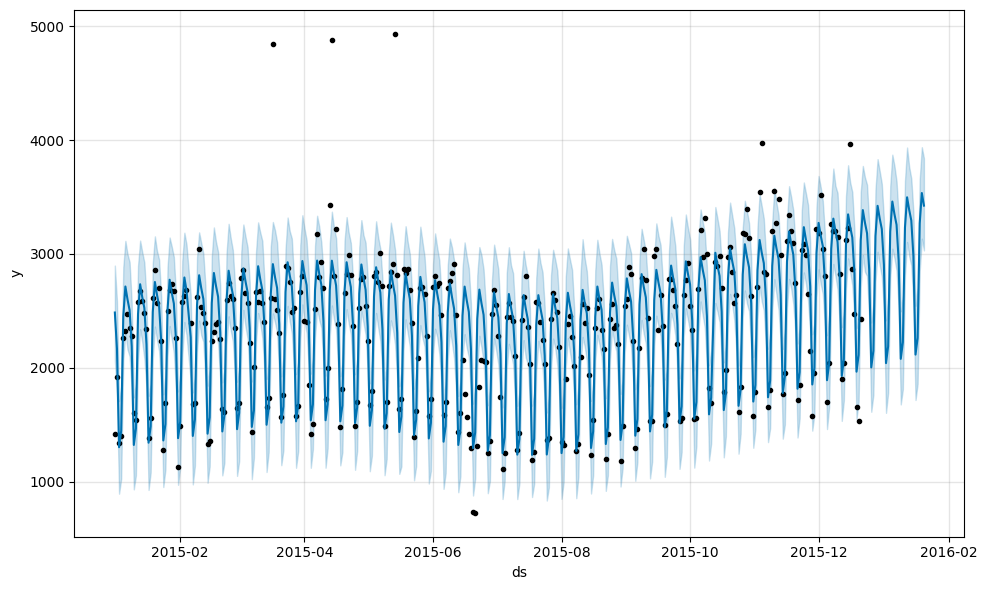

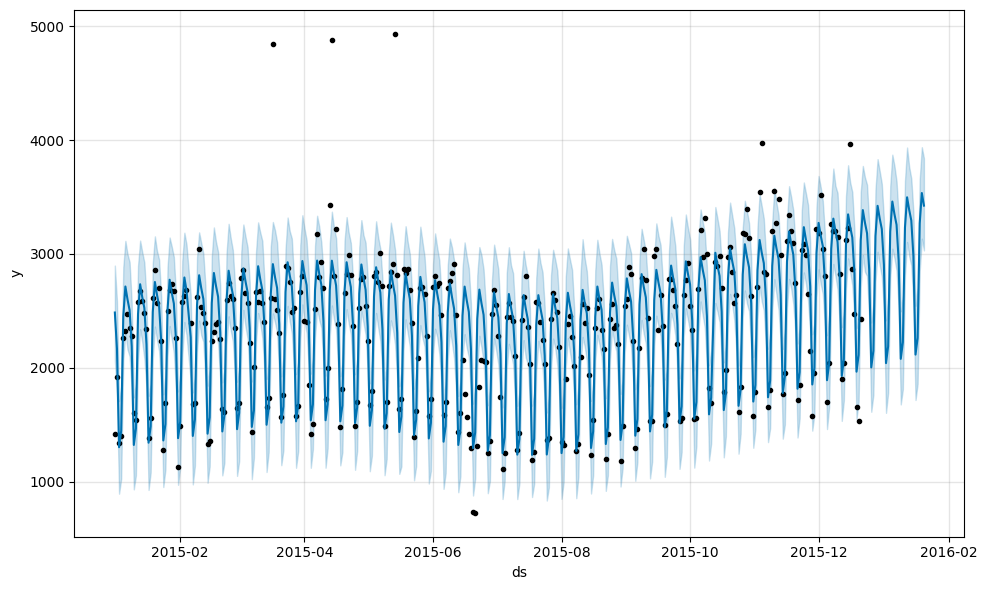

In [121]:
model_prophet.plot(forecast)

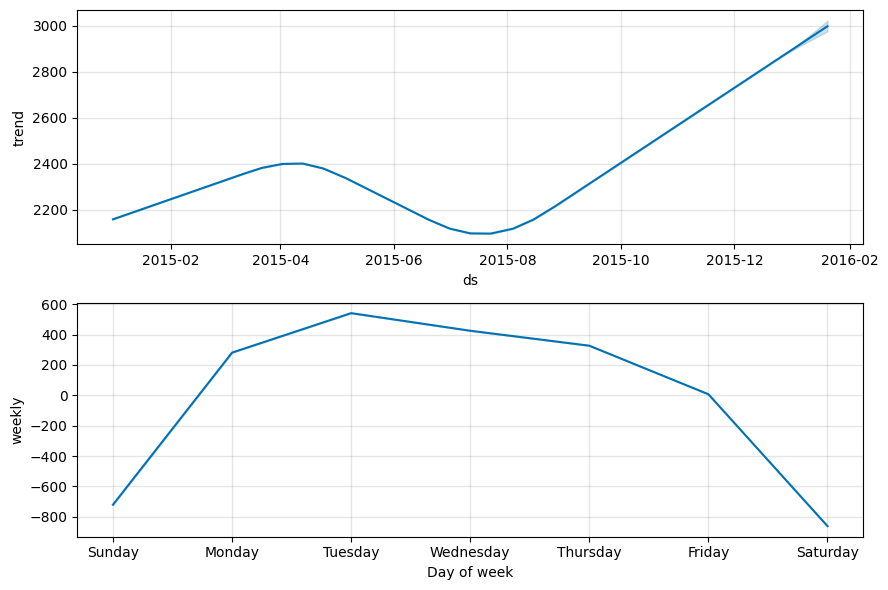

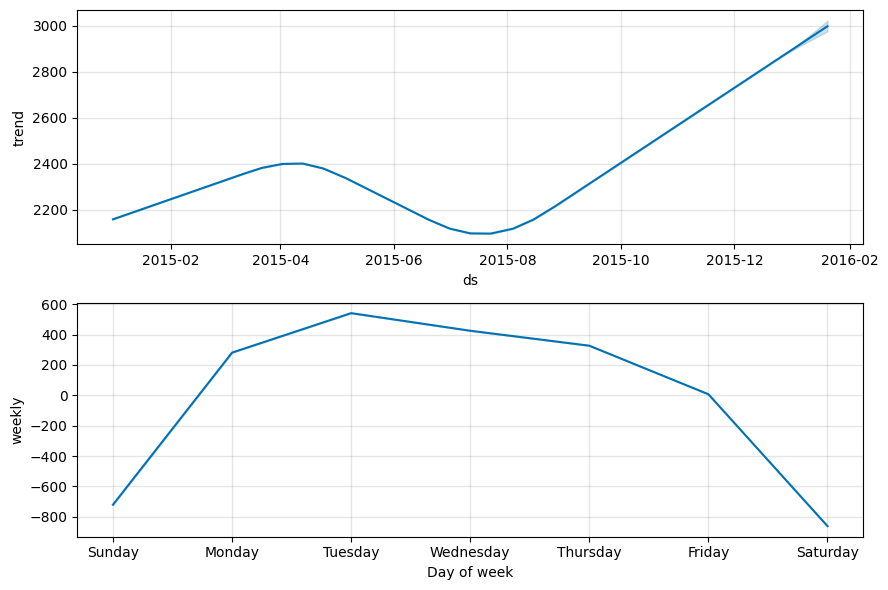

In [122]:
model_prophet.plot_components(forecast)

Для удобства заменим дефолт индексы на даты

In [123]:
DF_MODIFIED_FEATURES = ['yhat','yhat_lower','yhat_upper']

__df_date_indexed = df.set_index('ds')
df_modified = forecast.set_index('ds')[DF_MODIFIED_FEATURES].join(__df_date_indexed)

df_modified

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-01-01,2485.065336,2062.586136,2897.401167,1414
2015-01-02,2167.993522,1763.793063,2584.894848,1920
2015-01-03,1301.987206,893.577360,1707.563206,1338
2015-01-04,1445.782100,1023.042512,1833.971846,1404
2015-01-05,2450.763114,2064.408491,2882.579377,2264
...,...,...,...,...
2016-01-16,2115.440476,1716.594840,2544.827956,1644
2016-01-17,2261.764034,1857.179670,2706.160342,1836
2016-01-18,3269.273711,2848.709945,3657.129799,2983


In [124]:
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 383 entries, 2015-01-01 to 2016-01-20
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yhat        383 non-null    float64
 1   yhat_lower  383 non-null    float64
 2   yhat_upper  383 non-null    float64
 3   y           383 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 15.0 KB


* `yhat` - значение, которое прогнозируем
* `yhat_lower` - нижняя граница доверительного интервала
* `yhat_upper` - верхняя граница доверительного интервала
* `y` - реальное значение _(?)_



### Вопрос 2: Какое получилось `MAPE` ?
### Вопрос 3:  Какое получилось `MAE` ? 

Взглянем на метрики `MAPE` и `MAE`

In [125]:
df_modified['e'] = df_modified['y'] - df_modified['yhat']     # abs error
df_modified['p'] = 100 * df_modified['e'] / df_modified['y']  # percent error

metric_mape = np.mean(abs(df_modified[-predictions:]['p']))
metric_mae = np.mean(abs(df_modified[-predictions:]['e']))

print(f'MAPE: {metric_mape}')
print(f'MAE: {metric_mae}')

MAPE: 34.434921704478135
MAE: 598.3901307027409


Ошибка 34.43% по `MAPE` не лучший результат _(имхо)_

По отклонению в `598.39` также тяжело судить, но выглядит не как наилучший результат

<b> Как итог </b>: по моему мнению, значение этих метрик допустимо

---

### Ответ на вопрос 1: предсказание на <b> 20 января </b>

In [126]:
DATE_FOR_CHECK = '2016-01-20'

Наш прогноз

In [127]:
forecast_20_jan_value = forecast[forecast['ds'] == DATE_FOR_CHECK]['yhat'].iloc[0]

forecast_20_jan_value

3424.1167442478804

Реальное значение

In [128]:
real_20_jan_value =  df[df['ds']==DATE_FOR_CHECK]['y'].iloc[0]

real_20_jan_value

3559

Разница

In [129]:
diff_20_jan_value = real_20_jan_value - forecast_20_jan_value

diff_20_jan_value

134.88325575211957

_(вышло неплохо)_

---

Для того, чтобы визуализировать прогноз, воспользуемся `plotly` + собственной оберткой для дополнения интервалами на визуализации

In [130]:
# TODO: перенести в .shared.py

ENUM_COLORS = {
  'LIGHT_GREY': 'lightgrey',
  'RED': '#ff6a78',
  'RED_BACKGROUND_RGBA': 'rgba(255, 106, 120, 0.3)',
  'BLUE': 'BLUE',
  'BLACK': '#000000'
}


In [131]:
# TODO: перенести в .utils.py

def forecast_plot_wrap(df, num_predictions, num_values):
    # Верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=df.tail(num_predictions).index,
        y=df.tail(num_predictions).yhat_upper,
        mode='lines',
        line=dict(width=0),
        fillcolor=ENUM_COLORS['RED_BACKGROUND_RGBA'],
        fill='tonexty')

    # Нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=df.tail(num_predictions).index,
        y=df.tail(num_predictions).yhat_lower,
        line=dict(width=0),
        # fillcolor=ENUM_COLORS['RED_BACKGROUND_RGBA'],  # Нет смысла отображать, весь низ - граница
        # fill='tonexty',                                # Нет смысла отображать, весь низ - граница
        mode='lines')

    # Сам прогноз
    forecast_value = go.Scatter(
        name='Prediction',
        x=df.tail(predictions).index,
        y=df.tail(predictions).yhat,
        mode='lines',                                   # Хотел сделать dashes lines (- - -), но выглядит незаметно
        line=dict(color=ENUM_COLORS['BLUE']),
    )

    # Реальное значение
    real_value = go.Scatter(
        name='Real value',
        x=df.tail(num_values).index,
        y=df.tail(num_values).y,
        marker=dict(color=ENUM_COLORS['BLACK']),
        mode='lines',
    )

    fig_data = [lower_bound, upper_bound, forecast_value, real_value]
    layout = go.Layout()
    fig = go.Figure(data=fig_data, layout=layout)
    
    iplot(fig, show_link=False)

In [132]:
forecast_plot_wrap(df_modified, predictions, 200)

---

## Предсказание с помощью ARIMA

### Вопрос 4: Проверим стационарность ряда с помощью критерия Дики-Фулера. 

Является ли ряд стационарным? Какое значение `p-value` ?

На основе предыдущих лабораторных работ я сформировал утилиты для:
* Теста Дики Фуллера
* Проверки стационарности
* Отображения статистических показателей (дисперсия, среднее значение, p-value)

Копипастом добавлю в ячейку ниже (взято с [ЛР проверки стационарности](../time-series-stationarity/time-series-stationarity.notebook.ipynb))

In [133]:
# TODO: перенести в собственный глобальный пакет utils

def check_stationary(x, alpha=0.05):
    test_stat, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(x)
    is_stationary = False

    if p_value < alpha:
        is_stationary = True
      
    return {
        'p_value': p_value,
        'is_stationary': is_stationary
    }
    
def print_stationary(stationary_data):
    p_value = stationary_data['p_value']
    is_stationary = stationary_data['is_stationary']
  
    if is_stationary:
        print(f'Выборка является стационарной, значение p-value = {p_value} ')
        return

    print(f'Выборка не является стационарной, значение p-value = {p_value} ')
    
def print_full_test(noise, alpha=0.05):
  print_stationary(check_stationary(noise, alpha=alpha))
  print('\n')
  print('Тест Дики Фуллера', '\n', sm.tsa.stattools.adfuller(noise))
  

In [134]:
# TODO: перенести в собственный глобальный пакет utils

def stat_df(df, column):
  mean = round(df[column].mean(), 3)
  variance_computed = round(variance(df[column], 3))
  
  return {
    'mean': mean,
    'variance': variance_computed
  }

Проверим на стационарность + тест Дики Фуллера

In [135]:
print_full_test(df_modified['y'])

Выборка является стационарной, значение p-value = 0.01538366841946938 


Тест Дики Фуллера 
 (-3.2888636389431065, 0.01538366841946938, 15, 367, {'1%': -3.448294490928673, '5%': -2.869447722240253, '10%': -2.570982681065269}, 5332.027068742607)


Немного статистики

In [136]:
stat_df(df_modified, 'y')

{'mean': 2337.533, 'variance': 5899965}

### Вопрос 5: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). 

Модель c какими параметрами лучшая по AIC-критерию?

SARIMAX + автокорреляция

In [137]:
NUMBER_OF_LAGS = 40

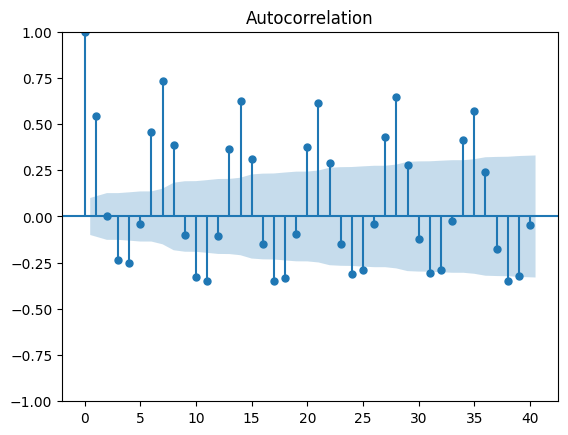

In [138]:
sm.graphics.tsa.plot_acf(df_modified['y'], lags=NUMBER_OF_LAGS)
plt.show()

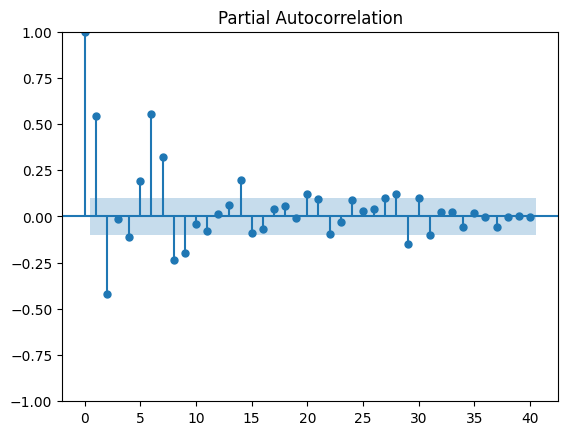

In [139]:

sm.graphics.tsa.plot_pacf(df_modified['y'], lags=NUMBER_OF_LAGS)
plt.show()

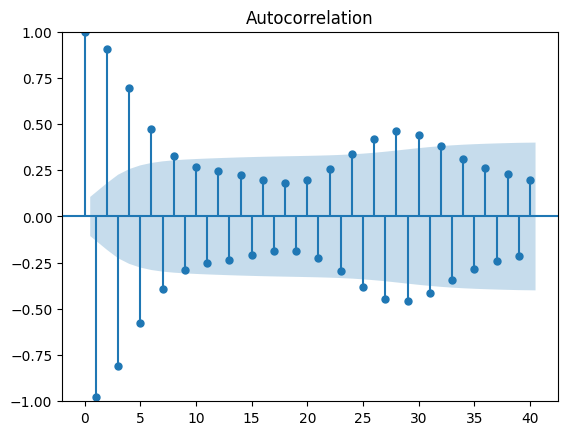

In [140]:
y_seasonal_diff = np.diff(df_modified['y'], NUMBER_OF_LAGS)

sm.graphics.tsa.plot_acf(y_seasonal_diff, lags=NUMBER_OF_LAGS)
plt.show()

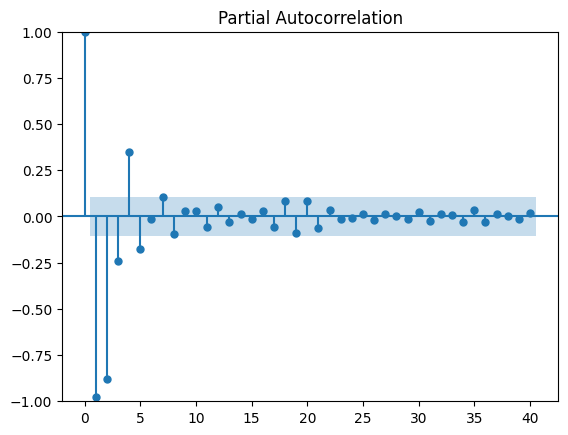

In [141]:
sm.graphics.tsa.plot_pacf(y_seasonal_diff, lags=NUMBER_OF_LAGS)
plt.show()

In [142]:
df_modified_y = df_modified['y'].reset_index()['y']

df_modified_y

0      1414
1      1920
2      1338
3      1404
4      2264
       ... 
378    1644
379    1836
380    2983
381    3389
382    3559
Name: y, Length: 383, dtype: int64

In [143]:
d = 1
D = 1

p = 2 # I - параметр сезонности
P = 1 # AR - порядок авторегрессии 

q = 1
Q = 1

In [144]:
model_sarimax = sm.tsa.statespace.SARIMAX(df_modified_y, order=(p,d,q), seasonal_order=(P,D,Q, 12))

In [145]:
model_sarimax_fit = model_sarimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75665D+00    |proj g|=  2.19532D-01


 This problem is unconstrained.



At iterate    5    f=  7.62685D+00    |proj g|=  5.37405D-02

At iterate   10    f=  7.61913D+00    |proj g|=  4.98060D-03

At iterate   15    f=  7.61717D+00    |proj g|=  7.26734D-04

At iterate   20    f=  7.61689D+00    |proj g|=  6.41469D-03

At iterate   25    f=  7.56513D+00    |proj g|=  2.05031D-01

At iterate   30    f=  7.47202D+00    |proj g|=  1.06398D-01

At iterate   35    f=  7.40555D+00    |proj g|=  2.07572D-02

At iterate   40    f=  7.40119D+00    |proj g|=  2.64654D-03

At iterate   45    f=  7.40067D+00    |proj g|=  7.12020D-03

At iterate   50    f=  7.40057D+00    |proj g|=  3.65786D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [146]:
print(model_sarimax_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  383
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2834.420
Date:                            Sun, 01 Dec 2024   AIC                           5680.840
Time:                                    00:44:37   BIC                           5704.321
Sample:                                         0   HQIC                          5690.167
                                            - 383                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7337      0.043     16.866      0.000       0.648       0.819
ar.L2         -0.4823      0.046   

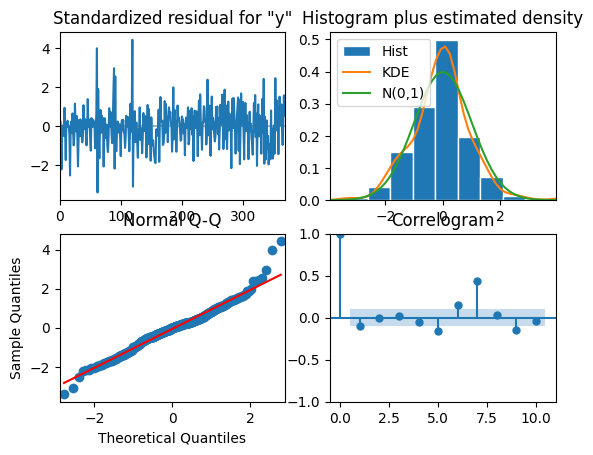

In [147]:
model_sarimax_fit.plot_diagnostics()
plt.show()

In [148]:
forecast_sarimax = model_sarimax_fit.get_forecast(30)

In [149]:
print(forecast_sarimax.predicted_mean)
print(forecast_sarimax.conf_int())

383    3073.064979
384    2479.189008
385    2189.392269
386    2348.846228
387    2469.109428
388    2593.975631
389    2640.724982
390    2777.193666
391    2699.828052
392    2480.886511
393    2480.143220
394    2462.997392
395    2486.199084
396    2614.823113
397    2738.908150
398    2708.955955
399    2574.730470
400    2637.363159
401    2641.240258
402    2563.574850
403    2564.019492
404    2634.510866
405    2703.636854
406    2721.605513
407    2635.351661
408    2608.407440
409    2641.980686
410    2653.254985
411    2573.971209
412    2649.560554
Name: predicted_mean, dtype: float64
         lower y      upper y
383  2102.917002  4043.212955
384  1226.503588  3731.874427
385   921.719239  3457.065300
386  1071.299990  3626.392466
387  1185.047153  3753.171702
388  1308.401660  3879.549603
389  1341.332321  3940.117642
390  1464.077124  4090.310208
391  1380.438235  4019.217869
392  1158.849831  3802.923191
393  1155.680266  3804.606173
394  1134.824513  3791.170271
395

In [150]:
predictions_sarimax = model_sarimax_fit.predict(start=0, end=df_modified_y.shape[0]+30)

predictions_sarimax

0         0.000000
1      1460.717088
2      1765.346876
3      1086.067619
4      1404.993591
          ...     
409    2641.980686
410    2653.254985
411    2573.971209
412    2649.560554
413    2663.490325
Name: predicted_mean, Length: 414, dtype: float64

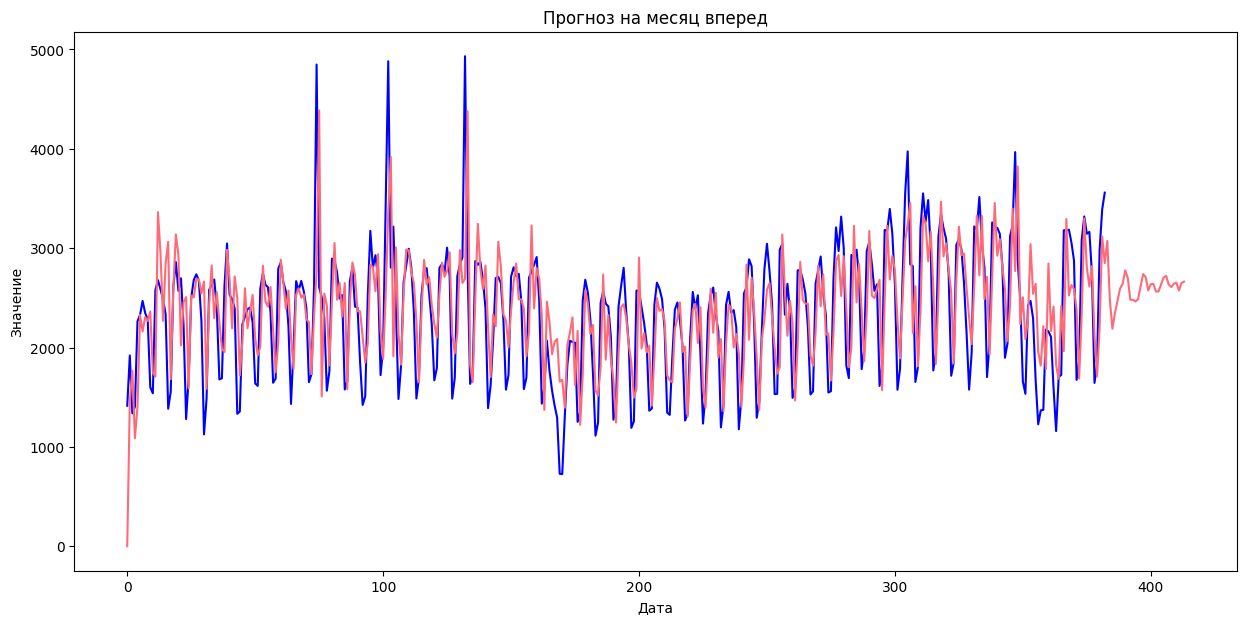

In [151]:
plt.figure(figsize=(15, 7))
plt.plot(df_modified_y, color=ENUM_COLORS['BLUE'], label="true")
plt.plot(predictions_sarimax, color=ENUM_COLORS['RED'], label="model")

plt.xlabel("Дата")
plt.ylabel("Значение")
plt.title("Прогноз на месяц вперед")

plt.show()

SARIMAX с подобором гиперапараметров

In [152]:
def plot_ts_wrap(y, lags=NUMBER_OF_LAGS, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
        
    return 

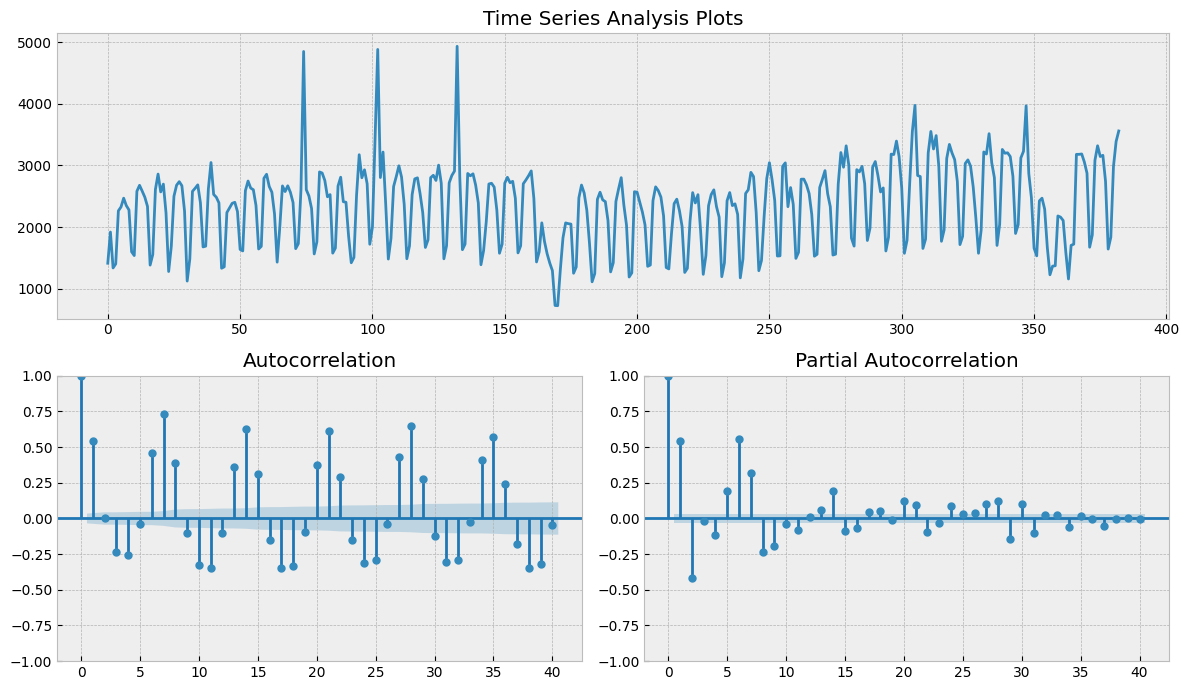

In [153]:
plot_ts_wrap(df_modified_y, lags=NUMBER_OF_LAGS)

In [154]:
print_full_test(df_modified_y, alpha=0.05)
stat_df(df_modified, 'y')

Выборка является стационарной, значение p-value = 0.01538366841946938 


Тест Дики Фуллера 
 (-3.2888636389431065, 0.01538366841946938, 15, 367, {'1%': -3.448294490928673, '5%': -2.869447722240253, '10%': -2.570982681065269}, 5332.027068742607)


{'mean': 2337.533, 'variance': 5899965}

Выборка является стационарной, значение p-value = 0.018576666139689342 


Тест Дики Фуллера 
 (-3.225106053002233, 0.018576666139689342, 15, 367, {'1%': -3.448294490928673, '5%': -2.869447722240253, '10%': -2.570982681065269}, 3748.7524043736344)
Оптимальный параметр преобразования Бокса-Кокса: 0.7266295614421038


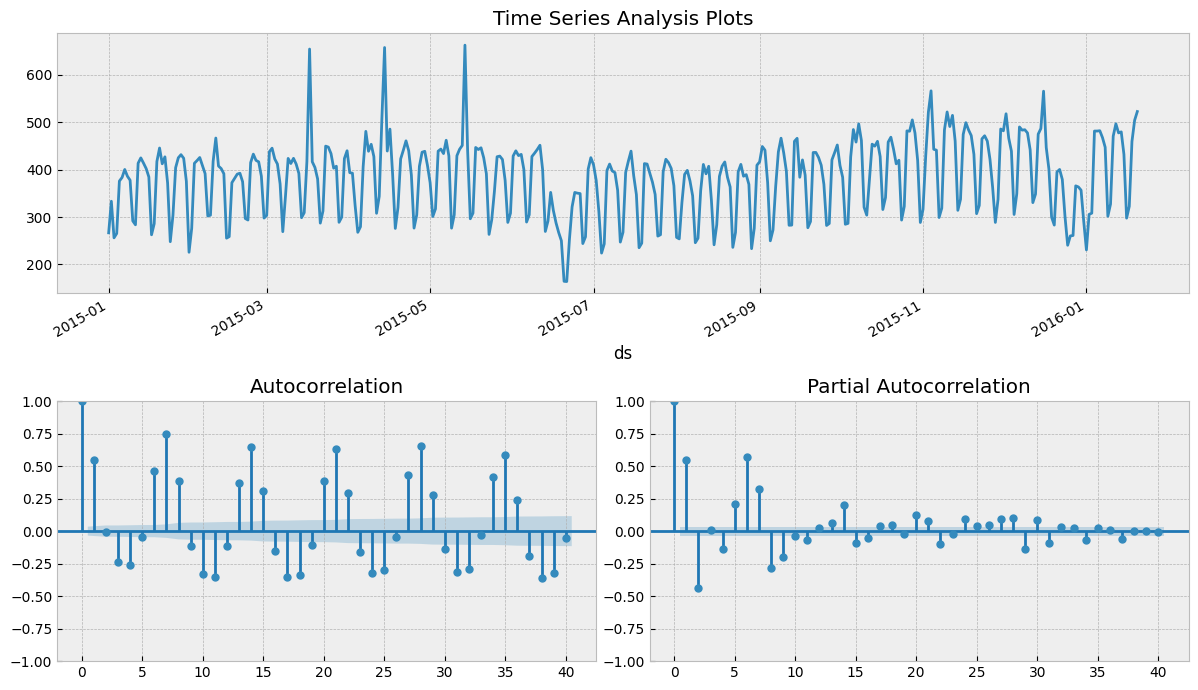

In [155]:
df_modified_y_box = df_modified.copy()
df_modified_y_box['y_box'], lambda_value = stats.boxcox(df_modified_y_box['y'] + 1) # добавляем 1, чтобы не было отрицательных значений или нулей

plot_ts_wrap(df_modified_y_box['y_box'])

print_full_test(df_modified_y_box['y_box'], alpha=0.05)
print(f"Оптимальный параметр преобразования Бокса-Кокса: {lambda_value}")

Выборка является стационарной, значение p-value = 0.002398598287601583 


Тест Дики Фуллера 
 (-3.8542462588717274, 0.002398598287601583, 7, 347, {'1%': -3.449336554273722, '5%': -2.8699055166063085, '10%': -2.571226758215748}, 3567.6252750684453)


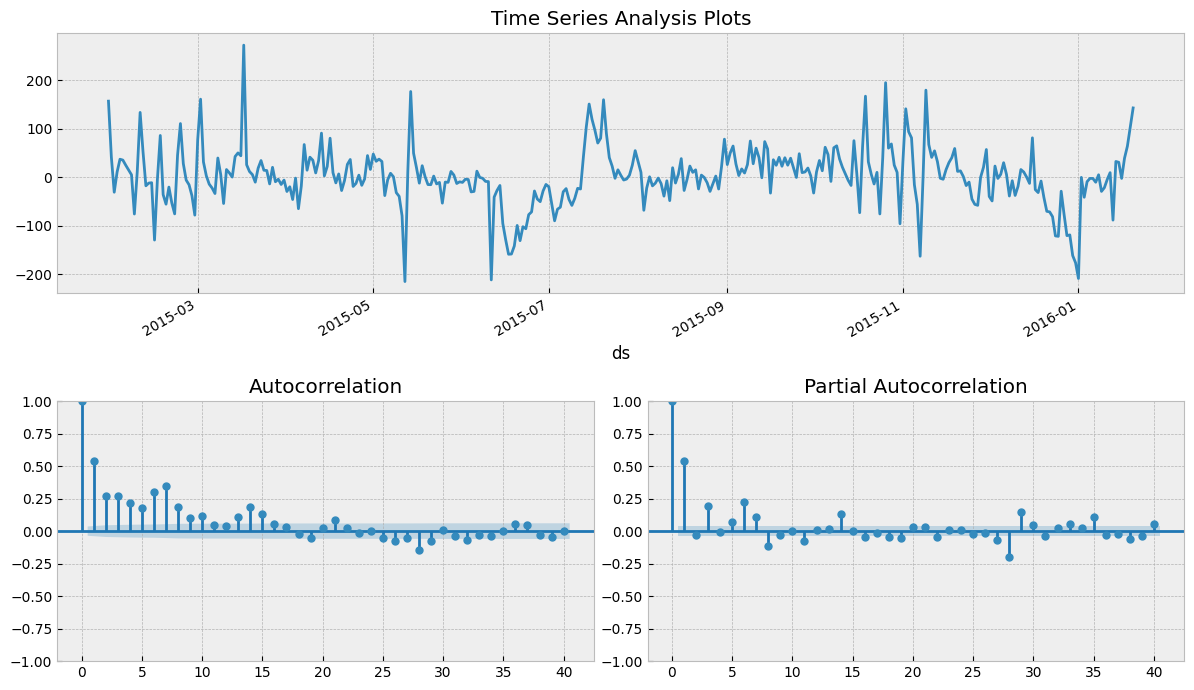

In [156]:
df_modified_y_box['y_box_season'] = df_modified_y_box['y_box'] - df_modified_y_box['y_box'].shift(28)

print_full_test(df_modified_y_box['y_box_season'][28:], alpha=0.05)
plot_ts_wrap(df_modified_y_box['y_box_season'][28:], lags=NUMBER_OF_LAGS)

Уже близко

Выборка является стационарной, значение p-value = 3.8654584520439385e-11 


Тест Дики Фуллера 
 (-7.517630260825112, 3.8654584520439385e-11, 12, 341, {'1%': -3.449673193310592, '5%': -2.8700533746644323, '10%': -2.5713055939491403}, 3566.641718942754)


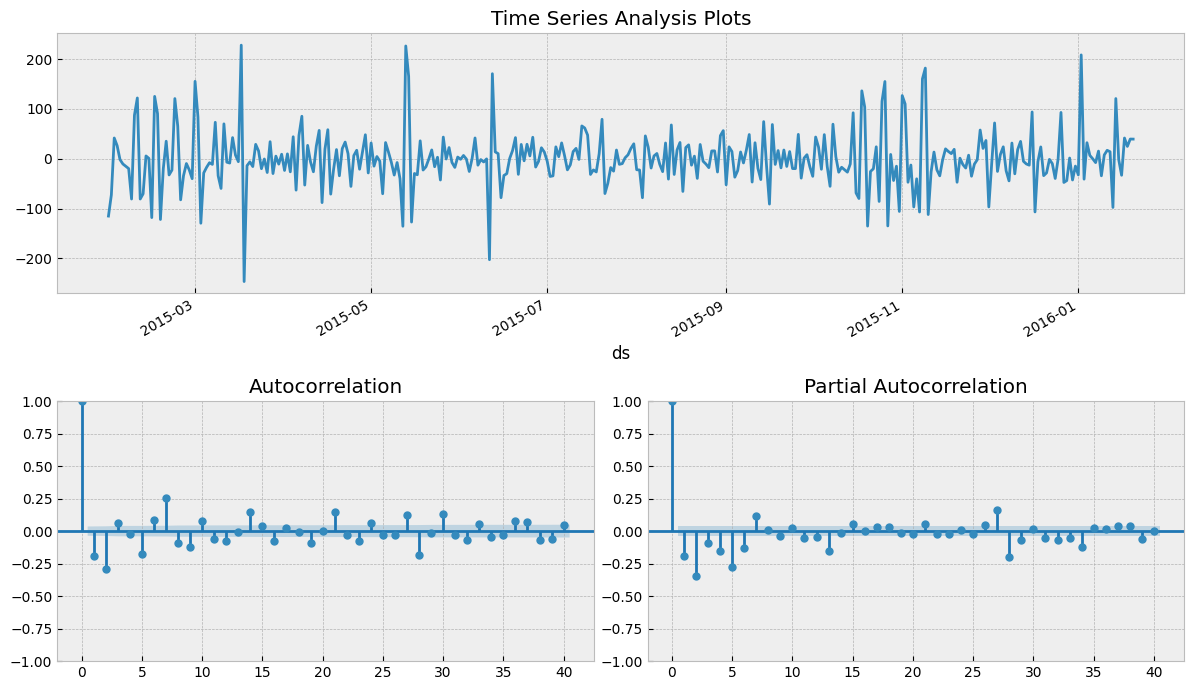

In [157]:
df_modified_y_box['y_box_season_diff'] = df_modified_y_box['y_box_season'] - df_modified_y_box['y_box_season'].shift(1) 

print_full_test(df_modified_y_box['y_box_season_diff'][28+1:], alpha=0.05)
plot_ts_wrap(df_modified_y_box['y_box_season_diff'][28+1:], lags=NUMBER_OF_LAGS)

Можно сказать, идеально, округлив `p-value` до 0.0

Собираем хорошую SARIMAX модель

In [158]:
ps = range(0, 5)

d=1

qs = range(0, 4)
Ps = range(0, 5)

D=1

Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

len(parameters_list)

100

In [159]:
%time

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 31 μs


На этом этапе лучше включить логироване

In [160]:
warnings.filterwarnings('default')

Закомментил код, потому что воркает очень долго и приходилось перезапускать ядро несколько раз...

In [161]:
# results = []
# best_aic = float("inf")

# for param in tqdm(parameters_list):
#     # Из-за того, что модель на некоторых параметрах не обучается, приходится костылить try except
#     try:
#         model_sarimax_optimized = sm.tsa.statespace.SARIMAX(df_modified_y_box.y_box, order=(param[0], d, param[1]), 
#                                         seasonal_order=(param[2], D, param[3], 28)).fit(disp=-1)
#     except ValueError:
#         # print('[WARNING]: wrong parameters:', param)
#         continue
      
#     aic = model_sarimax_optimized.aic
    
#     if aic < best_aic:
#         best_model = model_sarimax_optimized
#         best_aic = aic
#         best_param = param
    
#     results.append([param, model_sarimax_optimized.aic])


# result_table = pd.DataFrame(results)
# result_table.columns = ['parameters', 'aic']

# print(result_table.sort_values(by = 'aic', ascending=True).head())

Мои лучшие параметры - `(2, 1, 1, 0)`

Мой `AIC` - `3439.198784`

In [162]:
df_modified_y_box

,yhat,yhat_lower,yhat_upper,y,e,p,y_box,y_box_season,y_box_season_diff
ds,,,,,,,,,
2015-01-01,2485.065336,2062.586136,2897.401167,1414,-1071.065336,-75.747195,266.614474,NaN,NaN
2015-01-02,2167.993522,1763.793063,2584.894848,1920,-247.993522,-12.916329,333.276987,NaN,NaN
2015-01-03,1301.987206,893.577360,1707.563206,1338,36.012794,2.691539,256.076890,NaN,NaN
2015-01-04,1445.782100,1023.042512,1833.971846,1404,-41.782100,-2.975933,265.236957,NaN,NaN
2015-01-05,2450.763114,2064.408491,2882.579377,2264,-186.763114,-8.249254,375.829857,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2016-01-16,2115.440476,1716.594840,2544.827956,1644,-471.440476,-28.676428,297.607927,-1.978550,-33.181292
2016-01-17,2261.764034,1857.179670,2706.160342,1836,-425.764034,-23.189762,322.579122,39.635299,41.613849
2016-01-18,3269.273711,2848.709945,3657.129799,2983,-286.273711,-9.596839,459.493826,64.365057,24.729758


#### Финальная SARIMAX 

In [163]:
df_modified_y_box_M = df_modified_y_box.reset_index()['y_box']

In [164]:
df_modified_y_box_M

0      266.614474
1      333.276987
2      256.076890
3      265.236957
4      375.829857
          ...    
378    297.607927
379    322.579122
380    459.493826
381    504.255602
382    522.556468
Name: y_box, Length: 383, dtype: float64

In [165]:
best_model = sm.tsa.statespace.SARIMAX(df_modified_y_box_M, order=(2, 1, 2), seasonal_order=(1, 1, 0, 28), enforce_stationarity=False, enforce_invertibility=False)

In [166]:
best_model = best_model.fit(disp=True)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47214D+00    |proj g|=  6.15005D-02

At iterate    1    f=  4.47093D+00    |proj g|=  1.20904D-02

At iterate    2    f=  4.47082D+00    |proj g|=  7.85446D-03

At iterate    3    f=  4.47070D+00    |proj g|=  6.20243D-03

At iterate    4    f=  4.47063D+00    |proj g|=  3.19141D-03

At iterate    5    f=  4.47059D+00    |proj g|=  4.31749D-03

At iterate    6    f=  4.47056D+00    |proj g|=  3.71559D-03

At iterate    7    f=  4.47054D+00    |proj g|=  4.72844D-03

At iterate    8    f=  4.47038D+00    |proj g|=  9.52193D-03

At iterate    9    f=  4.47029D+00    |proj g|=  7.83053D-03

At iterate   10    f=  4.47018D+00    |proj g|=  2.25462D-03

At iterate   11    f=  4.47013D+00    |proj g|=  3.98886D-03

At iterate   12    f=  4.47009D+00    |proj g|=  6.59425D-03

At iterate   13    f=  4.4

Выборка является стационарной, значение p-value = 0.0011891954784286778 


Тест Дики Фуллера 
 (-4.045709612175737, 0.0011891954784286778, 14, 340, {'1%': -3.4497304638968043, '5%': -2.8700785273763487, '10%': -2.571319005190311}, 3556.2710543267103)


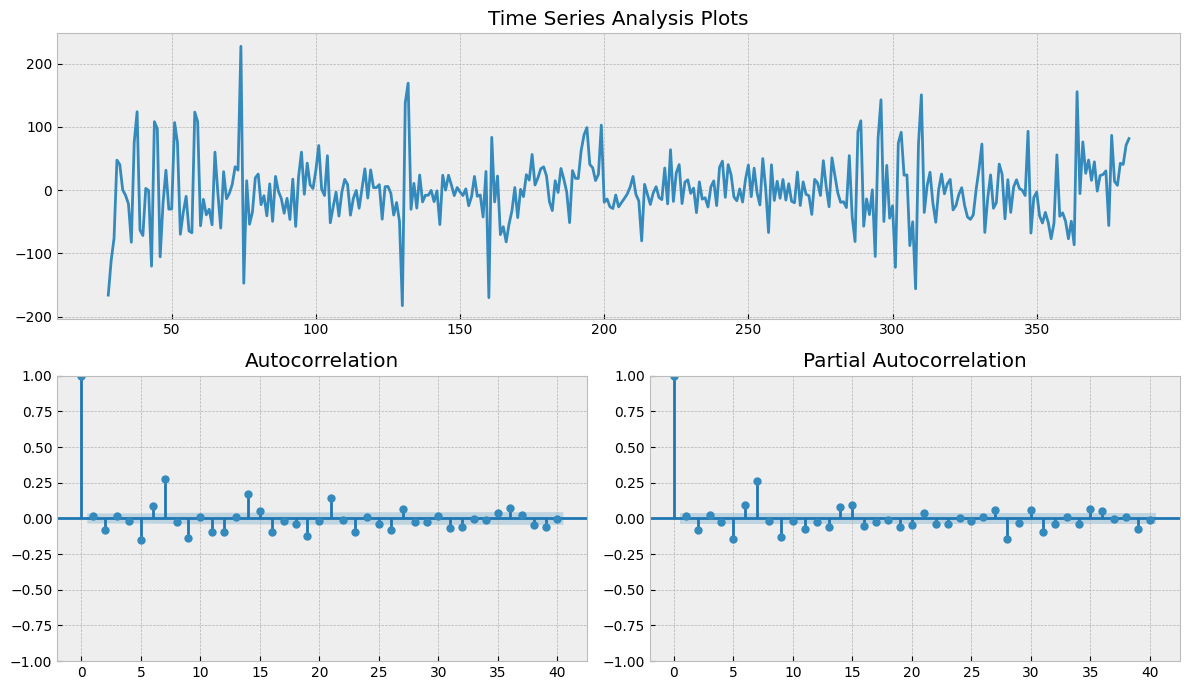

In [167]:
print_full_test(best_model.resid[28:], alpha=0.05)
plot_ts_wrap(best_model.resid[28:], lags=NUMBER_OF_LAGS)

In [168]:
lambda_value

0.7266295614421038

In [169]:
# Утилита преобразования бокс-кокса обратно (инвертер)
def box_cox_transform_back(y, lambda_value=lambda_value):
    if lambda_value == 0:
        return(np.exp(y))
      
    return(np.exp(np.log(y*lambda_value + 1) / lambda_value))

In [170]:
df_modified_y_box["arima_model"] = box_cox_transform_back(best_model.fittedvalues, lambda_value).to_list()

df_modified_y_box

,yhat,yhat_lower,yhat_upper,y,e,p,y_box,y_box_season,y_box_season_diff,arima_model
ds,,,,,,,,,,
2015-01-01,2485.065336,2062.586136,2897.401167,1414,-1071.065336,-75.747195,266.614474,NaN,NaN,1.000000
2015-01-02,2167.993522,1763.793063,2584.894848,1920,-247.993522,-12.916329,333.276987,NaN,NaN,1397.265598
2015-01-03,1301.987206,893.577360,1707.563206,1338,36.012794,2.691539,256.076890,NaN,NaN,1961.167147
2015-01-04,1445.782100,1023.042512,1833.971846,1404,-41.782100,-2.975933,265.236957,NaN,NaN,1361.984894
2015-01-05,2450.763114,2064.408491,2882.579377,2264,-186.763114,-8.249254,375.829857,NaN,NaN,1386.256298
...,...,...,...,...,...,...,...,...,...,...
2016-01-16,2115.440476,1716.594840,2544.827956,1644,-471.440476,-28.676428,297.607927,-1.978550,-33.181292,1588.002486
2016-01-17,2261.764034,1857.179670,2706.160342,1836,-425.764034,-23.189762,322.579122,39.635299,41.613849,1514.658917
2016-01-18,3269.273711,2848.709945,3657.129799,2983,-286.273711,-9.596839,459.493826,64.365057,24.729758,2627.894251


In [171]:
forecast = box_cox_transform_back(best_model.predict(start = df_modified_y_box_M.shape[0], end = df_modified_y_box_M.shape[0]+30), lambda_value)
forecast = df_modified_y_box.arima_model._append(forecast).values[-500:]

forecast

array([1.00000000e+00, 1.39726560e+03, 1.96116715e+03, 1.36198489e+03,
       1.38625630e+03, 2.25545630e+03, 2.35738413e+03, 2.46935300e+03,
       2.35748461e+03, 2.27693265e+03, 1.60852329e+03, 1.51932241e+03,
       2.56412251e+03, 2.71472542e+03, 2.58852277e+03, 2.48548086e+03,
       2.33602416e+03, 1.39351329e+03, 1.52390314e+03, 2.60422088e+03,
       2.89492542e+03, 2.58358972e+03, 2.68748335e+03, 2.24413266e+03,
       1.28027896e+03, 1.65358391e+03, 2.50599041e+03, 2.70603559e+03,
       4.20367430e+03, 3.22998425e+03, 1.67729320e+03, 1.14984219e+03,
       2.24207370e+03, 2.62682782e+03, 2.75843005e+03, 2.58035744e+03,
       2.33756939e+03, 1.14279437e+03, 1.61697325e+03, 3.62757328e+03,
       3.16151166e+03, 2.46279556e+03, 2.39999320e+03, 2.26195210e+03,
       6.47172485e+02, 1.48027302e+03, 3.23185403e+03, 2.55814410e+03,
       2.14269829e+03, 2.50627944e+03, 1.86717401e+03, 8.70164422e+02,
       1.97229867e+03, 3.37342247e+03, 2.94285383e+03, 2.69161927e+03,
      

In [172]:
actual = df_modified_y_box.y.values[-400:]

actual

array([1414, 1920, 1338, 1404, 2264, 2327, 2469, 2349, 2279, 1600, 1539,
       2581, 2678, 2584, 2485, 2336, 1384, 1556, 2612, 2860, 2571, 2697,
       2232, 1280, 1690, 2501, 2680, 2737, 2671, 2261, 1125, 1486, 2580,
       2630, 2685, 2395, 1679, 1691, 2617, 3047, 2530, 2485, 2393, 1333,
       1356, 2236, 2312, 2386, 2402, 2253, 1638, 1614, 2592, 2747, 2633,
       2606, 2351, 1645, 1688, 2792, 2857, 2659, 2566, 2214, 1432, 2004,
       2668, 2576, 2670, 2565, 2399, 1651, 1732, 2612, 4848, 2608, 2505,
       2302, 1565, 1760, 2895, 2877, 2757, 2492, 2527, 1578, 1660, 2666,
       2809, 2412, 2403, 1849, 1422, 1508, 2518, 3174, 2800, 2929, 2702,
       1722, 2002, 3428, 4881, 2804, 3217, 2384, 1482, 1816, 2659, 2819,
       2994, 2811, 2370, 1487, 1696, 2526, 2782, 2799, 2543, 2236, 1670,
       1794, 2802, 2840, 2757, 3005, 2714, 1486, 1697, 2718, 2837, 2908,
       4932, 2813, 1634, 1725, 2870, 2832, 2864, 2681, 2393, 1390, 1618,
       2086, 2699, 2711, 2649, 2277, 1576, 1724, 27

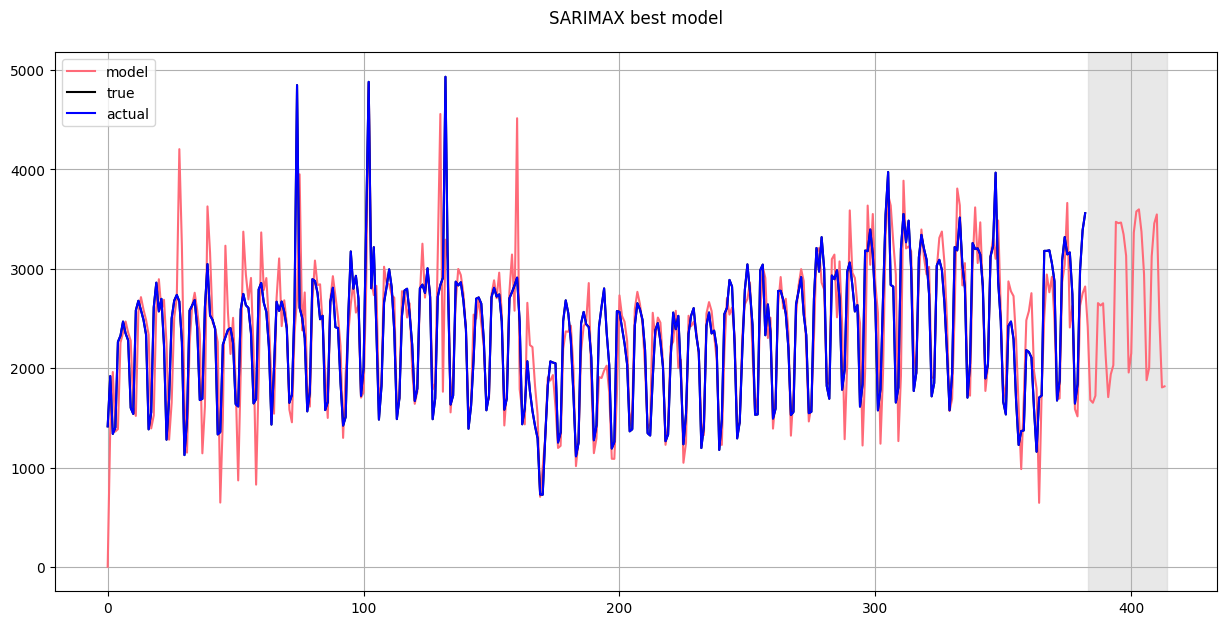

In [173]:
plt.figure(figsize=(15, 7))
plt.title(f"SARIMAX best model\n")

plt.plot(forecast, color=ENUM_COLORS['RED'], label="model")
plt.plot(df_modified_y, color=ENUM_COLORS['BLACK'], label = 'true')
plt.plot(actual, color=ENUM_COLORS['BLUE'], label="actual")

plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color=ENUM_COLORS['LIGHT_GREY'])
plt.grid(True)